In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
from glob import glob
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [2]:
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [3]:
train_path = "/content/drive/MyDrive/program/CitrusDigipathos/augmented/train"
valid_path = "/content/drive/MyDrive/program/CitrusDigipathos/augmented/valid"
test_path = "/content/drive/MyDrive/program/CitrusDigipathos/augmented/test"

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input) \
  .flow_from_directory(directory=train_path, target_size=(224,224), classes=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency'], batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input) \
  .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency'], batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input) \
  .flow_from_directory(directory=test_path, target_size=(224,224), classes=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency'], batch_size=32, shuffle=False)


Found 1084 images belonging to 6 classes.
Found 310 images belonging to 6 classes.
Found 151 images belonging to 6 classes.


In [5]:
imgs, labels = next(train_batches)

In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


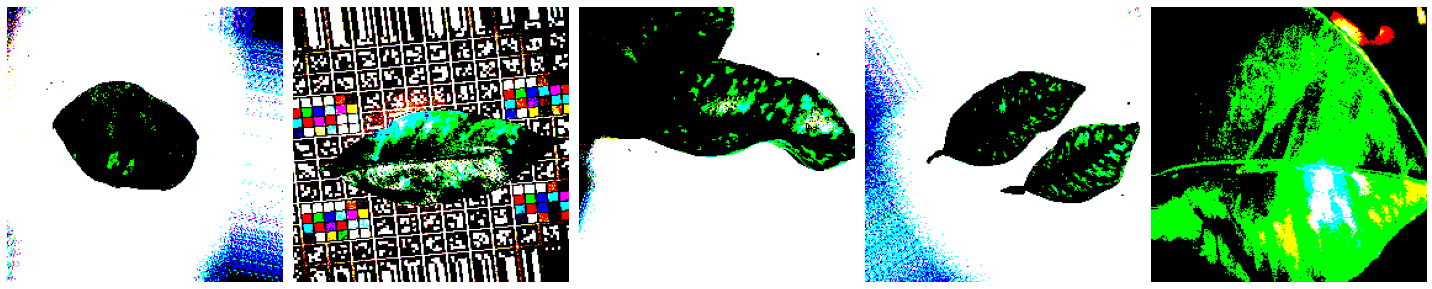

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]


In [7]:
plotImages(imgs)
print(labels)

In [8]:
vgg19_model = tf.keras.applications.vgg19.VGG19()

574726144/574710816 [==============================] - 5s 0us/step


In [9]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
model = Sequential()
for layer in vgg19_model.layers[:-1]:
  model.add(layer)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [12]:
for layer in model.layers:
  layer.trainable=False

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [14]:
model.add(Dense(units=6, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [16]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [18]:
model_path = '/content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_vgg19_model_v1.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [19]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=40,
  callbacks=callbacks_list
)

Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 1.8944 - accuracy: 0.3007
Epoch 1: val_accuracy improved from -inf to 0.52903, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_vgg19_model_v1.h5
34/34 [==============================] - 450s 13s/step - loss: 1.8944 - accuracy: 0.3007 - val_loss: 1.2140 - val_accuracy: 0.5290
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 0.9093 - accuracy: 0.6697
Epoch 2: val_accuracy improved from 0.52903 to 0.72581, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_vgg19_model_v1.h5
34/34 [==============================] - 212s 6s/step - loss: 0.9093 - accuracy: 0.6697 - val_loss: 0.7747 - val_accuracy: 0.7258
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 0.6072 - accuracy: 0.8035
Epoch 3: val_accuracy improved from 0.72581 to 0.79677, saving model to /content/drive/MyDrive/My ML Proje

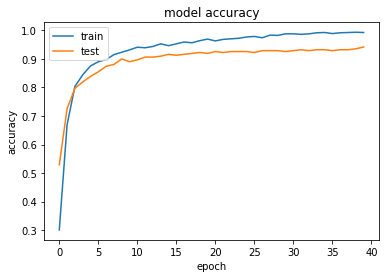

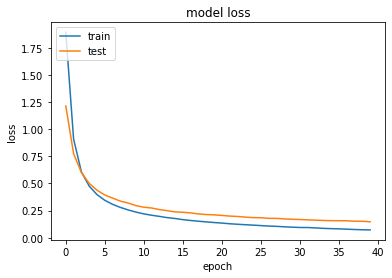

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=10,
  callbacks=callbacks_list
)

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.0706 - accuracy: 0.9926
Epoch 1: val_accuracy did not improve from 0.94194
34/34 [==============================] - 209s 6s/step - loss: 0.0706 - accuracy: 0.9926 - val_loss: 0.1439 - val_accuracy: 0.9323
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9945
Epoch 2: val_accuracy did not improve from 0.94194
34/34 [==============================] - 202s 6s/step - loss: 0.0684 - accuracy: 0.9945 - val_loss: 0.1443 - val_accuracy: 0.9355
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9935
Epoch 3: val_accuracy did not improve from 0.94194
34/34 [==============================] - 203s 6s/step - loss: 0.0650 - accuracy: 0.9935 - val_loss: 0.1422 - val_accuracy: 0.9323
Epoch 4/10
34/34 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9945
Epoch 4: val_accuracy did not improve from 0.94194
34/34 [=======================

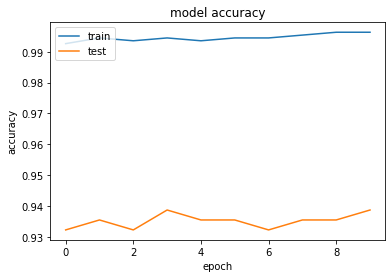

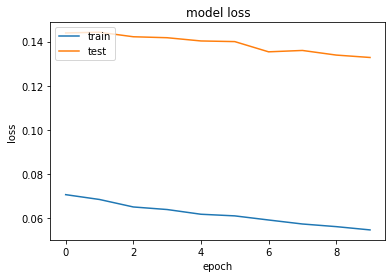

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
predictions = model.predict(x=test_batches, verbose=0)

In [24]:
rounded_predictions = np.argmax(predictions, axis=-1)

In [25]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=rounded_predictions)

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
test_batches.class_indices

{'Citrus Greasy Spot': 1,
 'Citrus canker': 0,
 'Citrus variegated chlorosis': 2,
 'Halo Blight': 3,
 'Mosaic': 4,
 'Nutritional Deficiency': 5}

Confusion matrix, without normalization
[[18  0  0  0  0  0]
 [ 0 16  0  0  0  0]
 [ 0  0 55  0  0  0]
 [ 0  0  0 10  0  0]
 [ 0  0  2  0 27  1]
 [ 0  0  2  0  1 19]]


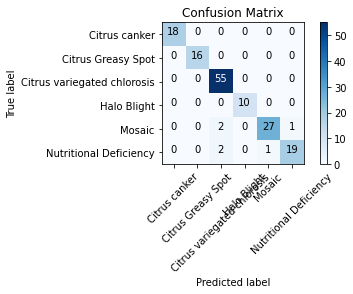

In [28]:
cm_plot_labels=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [29]:
from sklearn.metrics import classification_report

In [30]:
cr = classification_report(y_true=test_batches.classes, y_pred=rounded_predictions, target_names=cm_plot_labels)
print(cr)

                             precision    recall  f1-score   support

              Citrus canker       1.00      1.00      1.00        18
         Citrus Greasy Spot       1.00      1.00      1.00        16
Citrus variegated chlorosis       0.93      1.00      0.96        55
                Halo Blight       1.00      1.00      1.00        10
                     Mosaic       0.96      0.90      0.93        30
     Nutritional Deficiency       0.95      0.86      0.90        22

                   accuracy                           0.96       151
                  macro avg       0.97      0.96      0.97       151
               weighted avg       0.96      0.96      0.96       151

